In [1]:
import openferro as of
from openferro.interaction import *
from openferro.simulation import *

In [8]:
latt = of.BravaisLattice3D(6, 6, 6)
pto = of.System(latt, pbc=True)
dipole_field = pto.add_field(name="dipole", ftype="scalar", value=0.75)

double_well = self_energy_R1_onsite
pto.add_self_interaction('double_well', field_name="dipole", energy_engine=double_well, parameters={'k2': -0.2, 'alpha': 0.2, 'offset': 0}, enable_jit=True)

ising_couple = self_energy_R1_neighbor_pbc
pto.add_self_interaction('ising_couple', field_name="dipole", energy_engine=ising_couple, parameters={'J1': -0.02, 'J2': -0.02, 'J3': -0.02, 'offset': 0}, enable_jit=True)

print('mass:', pto.get_field_by_name('dipole').get_mass().flatten())
pto.update_force()
print('max force before optimization',pto.get_field_by_name("dipole").get_force().max())
print('average field before optimization',pto.get_field_by_name("dipole").get_values().mean())
minimizer = MDMinimize(pto, max_iter=100, tol=1e-5, dt=0.1)
minimizer.minimize()
equilibrium_field = pto.get_field_by_name("dipole").get_values().copy()
print('max force after optimization',pto.get_field_by_name("dipole").get_force().max())
print('average field after optimization',pto.get_field_by_name("dipole").get_values().mean()) 




mass: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
max force before optimization 0.052499995
average field before optimization 0.75
max force after optimization 8.970499e-06
average field after optimization 0.80621517


In [9]:
temp_list = [300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]
average_field = np.zeros(len(temp_list))
log_freq = 100 
total_time = 30
dt = 0.001
relax_steps = int(10/dt)
total_steps = int(total_time / dt)
niters = total_steps // log_freq

for it, temperature in enumerate(temp_list):
    simulation = SimulationNVTLangevin(pto, dt=dt, temperature=temperature, gamma=1/(1000*dt))
    simulation.system.get_field_by_name('dipole').set_values(equilibrium_field.copy())
    simulation.init_velocity(mode='gaussian')
    simulation.step(relax_steps)
    for ii in range(niters):
        simulation.step(log_freq)
        # print('velocity:', pto.get_field_by_name('dipole').get_velocity().flatten())
        # print('field:', pto.get_field_by_name('dipole').get_values().flatten())
        pot_E = pto.calc_potential_energy()
        kin_E = pto.calc_kinetic_energy()
        total_E = pot_E + kin_E
        average_field[it] += pto.get_field_by_name('dipole').get_values().mean() / niters
        print('=================T={}K, iter={}======================='.format(temperature, ii))
        # print('pot energy:', pot_E)
        # print('kine energy:', kin_E)
        # print('total energy:', total_E)
        print('temperature:', pto.calc_temp_by_name('dipole'))
        print('average field:', average_field)
        # print('field:', pto.get_field_by_name('dipole').get_values().flatten())

=================T=300K, iter=0=======================
temperature: 278.076
average field: [0.00246445 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
=================T=300K, iter=1=======================
temperature: 282.79535
average field: [0.00493051 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
=================T=300K, iter=2=======================
temperature: 279.8943
average field: [0.0073989 0.        0.        0.        0.        0.        0.
 0.        0.        0.       ]
=================T=300K, iter=3=======================
temperature: 273.1698
average field: [0.00987008 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
=================T=300K, iter=4=======================
temperature: 265.27985
average field: [0.01234494 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
=================T=300K

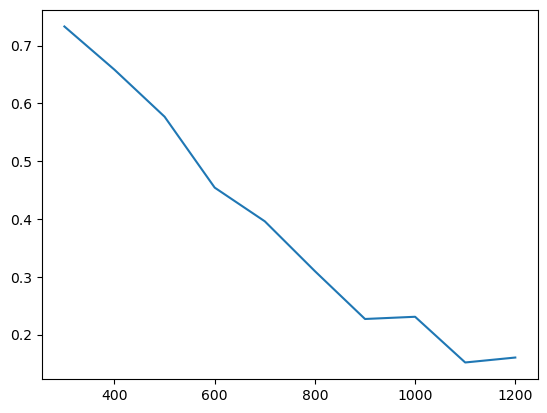

In [10]:
plt.plot(temp_list, average_field)

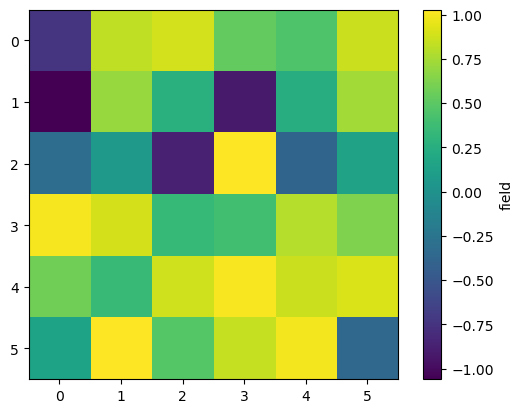

In [5]:
from matplotlib import pyplot as plt
plt.imshow(pto.get_field_by_name('dipole').get_values()[:,:,0,0])
colorbar = plt.colorbar()
colorbar.set_label('field')
plt.show()